In [1]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# Paths
RAW_DIR = Path("../data/raw")
INTERIM_DIR = Path("../data/interim")
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

# Which split to audit
SPLIT = "test"  # change to "valid" or "test" as needed

SRC_IMG_DIR = RAW_DIR / SPLIT / "images"
SRC_LBL_DIR = RAW_DIR / SPLIT / "labels"
DST_IMG_DIR = INTERIM_DIR / SPLIT / "images"
DST_LBL_DIR = INTERIM_DIR / SPLIT / "labels"

DST_IMG_DIR.mkdir(parents=True, exist_ok=True)
DST_LBL_DIR.mkdir(parents=True, exist_ok=True)

In [25]:
all_images = sorted(SRC_IMG_DIR.glob("*.*"))
print(f"Found {len(all_images)} images in {SRC_IMG_DIR}")

Found 1700 images in ..\data\raw\test\images


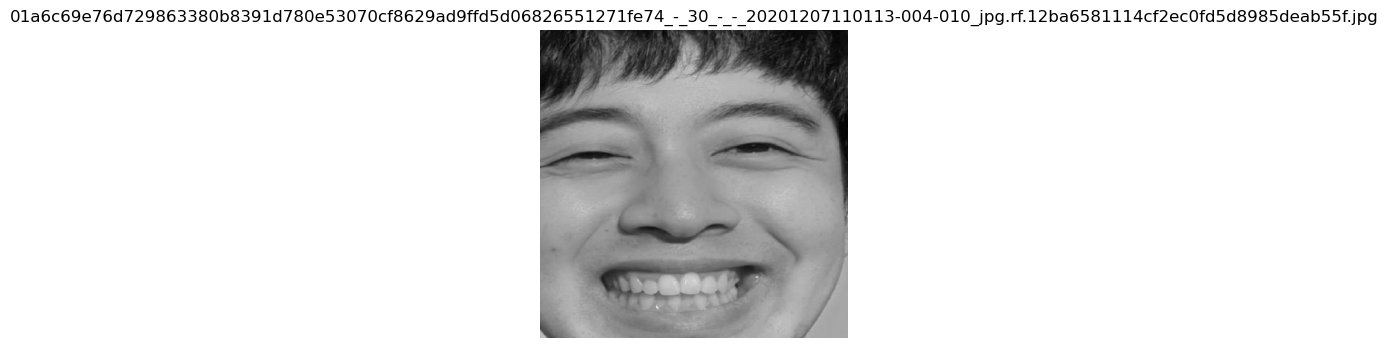

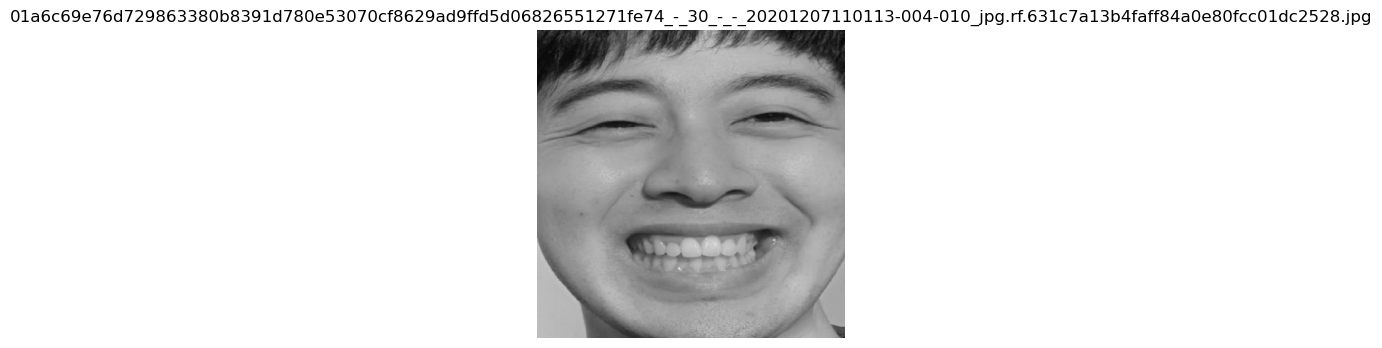

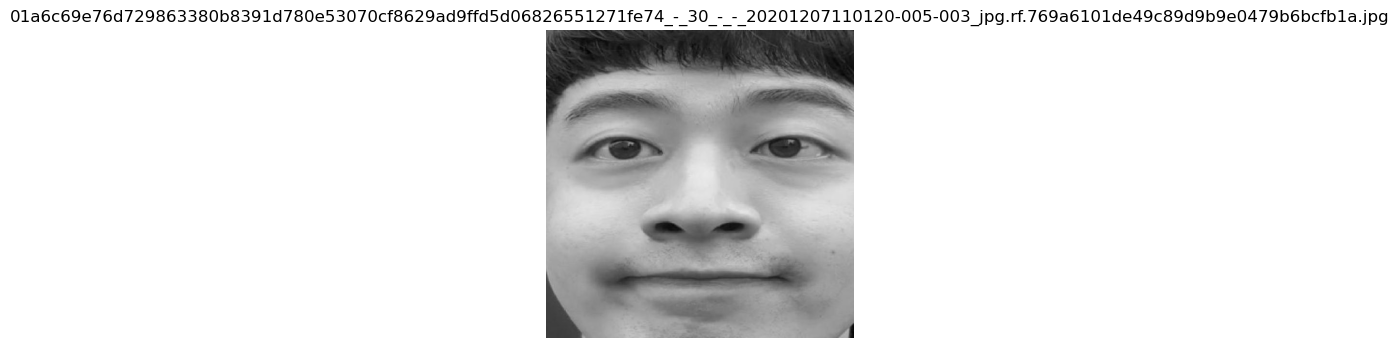

In [ ]:
# Show first 3
for img_path in all_images[:3]:
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(img_path.name)
    plt.axis("off")

In [27]:
# Cell 3: Ensure we have a Haar cascade (download if needed) and load it

import cv2, shutil
from pathlib import Path
import urllib.request

# Choose a local cache directory for cascades
CASCADE_DIR = Path("../data/external") / "haarcascades"
CASCADE_DIR.mkdir(parents=True, exist_ok=True)

# Local path where we expect the file
cascade_path = CASCADE_DIR / "haarcascade_frontalface_alt.xml"

# If it doesn’t exist, download from the OpenCV repo
if not cascade_path.exists():
    url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml"
    print(f"Downloading Haar cascade from {url} …")
    urllib.request.urlretrieve(url, str(cascade_path))
    print(f"Saved to {cascade_path}")

# Load the cascade
face_cascade = cv2.CascadeClassifier(str(cascade_path))
assert not face_cascade.empty(), f"Failed to load cascade at {cascade_path}"
print("Loaded cascade from:", cascade_path)


Loaded cascade from: ..\data\external\haarcascades\haarcascade_frontalface_alt.xml


In [28]:
# clean_paths = []

# for img_path in all_images:  # limit for speed; remove [:100] to process all
#     img = cv2.imread(str(img_path))
#     if img is None:
#         continue
#     gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
#     if len(faces) != 1:
#         continue

#     x, y, w, h = faces[0]
#     face       = img[y:y+h, x:x+w]
#     face_resized = cv2.resize(face, (640, 640))

#     out_path = INTERIM_DIR / img_path.name
#     cv2.imwrite(str(out_path), face_resized)
#     clean_paths.append(out_path)

# print(f"Saved {len(clean_paths)} cleaned crops to {INTERIM_DIR}")


In [ ]:
clean_paths = []
for img_path in all_images:
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    if len(faces) != 1:
        continue

    # 2) Crop & resize
    x, y, w, h = faces[0]
    crop = img[y : y + h, x : x + w]
    face_resized = cv2.resize(crop, (640, 640))

    # 3) Save to interim/<split>/images
    out_img = DST_IMG_DIR / img_path.name
    cv2.imwrite(str(out_img), face_resized)
    clean_paths.append(out_img)

    # 4) Copy the matching YOLO label
    lbl_src = SRC_LBL_DIR / f"{img_path.stem}.txt"
    lbl_dst = DST_LBL_DIR / lbl_src.name
    if lbl_src.exists():
        shutil.copy(str(lbl_src), str(lbl_dst))

print(f"[{SPLIT}] saved {len(clean_paths)} crops → {DST_IMG_DIR}")
print(f"[{SPLIT}] copied labels → {DST_LBL_DIR}")


[test] saved 1164 crops → ..\data\interim\test\images
[test] copied labels → ..\data\interim\test\labels


In [ ]:
from prettytable import PrettyTable

splits = ["train", "valid", "test"]
table = PrettyTable(["Split", "Original #", "Kept #", "Keep %"])

for split in splits:
    orig = len(list((RAW_DIR / split / "images").glob("*.*")))
    kept = len(list((INTERIM_DIR / split / "images").glob("*.*")))
    table.add_row([split, orig, kept, f"{kept / orig * 100:.1f}%"])

print(table)


+-------+------------+--------+--------+
| Split | Original # | Kept # | Keep % |
+-------+------------+--------+--------+
| train |   64864    | 44449  | 68.5%  |
| valid |    1720    |  1191  | 69.2%  |
|  test |    1700    |  1164  | 68.5%  |
+-------+------------+--------+--------+


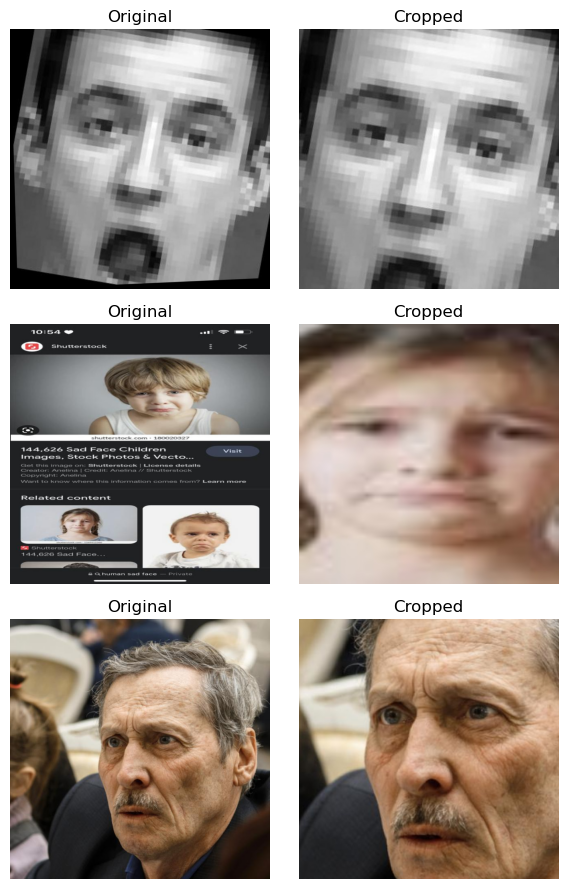

In [ ]:
import random, matplotlib.pyplot as plt

# pick 3 random images from "train"
samples = random.sample(list((INTERIM_DIR / "train" / "images").glob("*.*")), 3)
fig, axs = plt.subplots(3, 2, figsize=(6, 9))

for i, img_path in enumerate(samples):
    orig = cv2.cvtColor(
        cv2.imread(str(RAW_DIR / "train" / "images" / img_path.name)), cv2.COLOR_BGR2RGB
    )
    crop = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    axs[i, 0].imshow(orig)
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(crop)
    axs[i, 1].set_title("Cropped")
    axs[i, 1].axis("off")
plt.tight_layout()


In [ ]:
missing = []
for split in splits:
    for img_path in (INTERIM_DIR / split / "images").glob("*.jpg"):
        lbl = INTERIM_DIR / split / "labels" / f"{img_path.stem}.txt"
        if not lbl.exists():
            missing.append((split, img_path.name))
print("Missing labels:", missing[:10])


Missing labels: []
